# Handout 4 (FYD600/GU): Deep Q-learning, Grid world
### Authors: Jonatan Wårdh, Mats Granath, and Oleksandr Balabanov

(2019, revised 2020)

In this last homework we will continue on the previous project, the homework 3 Grid World, but we will now use a neural network to store the $Q$-matrix.

In the last Homework we found a $Q$-matrix that described the values of taking the action up,down,left or right given the state we were in. The state was given by the position of the player which lived on a 20x30 grid corresponding to 600 possible states; the state space. The $Q$-matrix was pretty small and we had no problem storing all the values and go through them many times and update until the values converged. However, this smallness of the state space is more an exception than a general rule.

In this assignment we will include a little twist to the game, a twist that makes the state space explode. What we will do is to let the fire spread with a certain probability after every turn of the player. For the sake of relative simplicity we will consider a 10x10 grid. The player has 100 possible positions but the fire can occupy any grid, or not, meaning that we have $100 \cdot 2^{100} \approx 10^{32}$ possible states. This is a huge number and there is no way of even storing this number of $Q$-matrix entries, even less so going through and updating all these values repeatedly. Of course, in principle the problem sounds quite simple. There should be no need to tune $10^{32}$ degrees of freedoms to learn the simple task of just avoiding the fire, but exactly how to capture that intuition in a self learning mathematical framework is less clear. (An alternative could be to use a rule based solution, but that has limited generalizability, and we do machine learning in this course.) This is where the neural network comes in. As we have seen in handout 1 and 2 a network has the possibility to learn general features of data. For the present problem it amounts to taking the state as an input and giving the value of the different actions as an output, i.e. we use the network to represent the $Q$-matrix. As you will see you will actually only need a very small number of parameters (compared to $10^{32}$) in your network to solve this problem.

The ground breaking paper that popularized deep Q-learning: [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236)


## Training

So what we need to alter from problem 3 is to implement the network as the $Q$-function. The update of the $Q$-function: $Q(s,a)\leftarrow(1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$, must then be replaced with the learning step of the network. This step meant that $r+\gamma\max_{a'}Q(s',a')$ was the new estimate of $Q(s,a)$, thus using the neural network we will then train on $r+\gamma\max_{a'}Q(s',a')$. 

So far everything seems like a straight forward generalization. However training the network is a quite tricky business. We will review a few problems and cures below. 


###  Catastrophic forgetting and experience replay

The first problem one might encounter when using the network instead of simply going through all the values of the $Q$-matrix is that of catastrophic forgetting. This is easiest explained with an example; Let's assume that the player has the goal on its left hand side and the cliff on its right hand side. It now takes a step to the left and receive a reward for this, the network is then trained on this situation and learns to correlates some  feature of this state to the action of taking a step to the left. In the next game it might happen so that the player ends up with the goal to the right and the cliff to the left. With the network being trained on this the previous move it might see some common features of these two states and decides to make a move to the left, because it was what it had learned last time. However this time this results in a negative reward and is we now train on this event it is likely that the network erase what it previously learned. In this scenario we might go back and forth between these two events and not learn anything. 

Note that this could not happen if we had the complete $Q$ matrix entries for every single state, simply because the experiences are disjoint; updating one element of the $Q$-matrix will not effect any other value. However, for the network, training on one state will effect the output of another state. So the very property that make networks good for treating a large state space make them sensitive in this regard.

So how do we solve this? Well we need to make the network learn to tell the qualitative difference between the two states and actions it apparently thought looked quite similar. What we do is then to train on both experiences simultaneously or at least repetively. In practice this is done by setting up a memory in which we store a certain number of the most recent experiences. When we come to the training we draw a random sample from this memory and train on it. This is called experience replay.

### Instability : Policy and target networks

Another issue is that the network may become unstable and the training might start to diverge. This problem comes partly from the fact that we use the network in order to predict future rewards, rewards that in the beginning are completely random. This means that the network will learn from its own prediction which can lead to a runaway situation. A cure for this is to use two networks: a _policy_ network and a _target_ network. These networks should have exactly the same architecture, they are just updated in different pace. The policy network determines the action of the player and is the network which is trained in the training step. The target network determines the target of the training, that is predicts $\max_{a'}Q(s',a')$, and is updated less frequently. The target network is updated by copying the weights of the policy network and assigning them to the target network, so the target network is never trained, it is just a copy of the policy network. By delaying the feedback to the target values in the training step the instability might be avoided.


# Assignment

You will be provided with a code that implements the grid world game. Your task is to make a suitable network, and find suitable parameters. There is not a lot of coding required, but getting it to work may require a few attempts. Below follows a brief description of the code.


## Code:

The code defines a class GridWorld, if you need to read up on classes check [w3schools](https://www.w3schools.com/python/python_classes.asp) for a short version and [The Python tutorial](https://docs.python.org/2/tutorial/classes.html) for a more extensive one. However the main point of classes is that you treat objects (or instances) of that class. You do this by calling the constructor to get an object of the class, e.g. below we write <code>world = GridWorld()</code> to get the object <code>world</code> of the class. Now you can call any function of variable in the class by <code>world.variable</code> or <code>world.function(parameters)</code>.


### State representation

To represent the state we have used an array consisting of three 10x10 grid layers. The first specifies the position of the player with a 1 at the position of the player, otherwise zero, if the player has walked outside the grid all elements are zero. The second layer specifies the position of the fire, with 1 where there is a fire and 0 otherwise. The third layer represents the goal and is fixed at the same position. I.e. <code>state[:,:,0]</code> gives the grid describing the position of the player, <code>state[:,:,1]</code> position of the fire and <code>state[:,:,2]</code> position of the goal.

## Questions and hints

Questions:

$\bf{1}$   Design and train a Q-networks that solves the Grid World game with a fire of probability <code>prob_spread = 0.5</code> and <code>wind = 0</code> for a 10 by 10 grid. This is your main task, and required to pass. Plot the state value function for different configurations of the fire. Study also the dynamical play of the player. Success implies that the agent (most of the time) manages to move from start (position [1,8]) to goal (position [8,1]) while avoiding the fire.

$\bf{2}$ (Optional) Explore what happens if you increase <code>prob_spread</code> and include  <code>wind</code>.


Below follows some hints. Note that the parameter values stated are not in any way correct values, it is just there to help you search in an appropriate parameter range

$\bullet$ Your network should not need more than 100000 parameters. But it might vary. Consider the activation function of the output nodes and the loss function.  

$\bullet$ To test the minimal requirements on your network you might want to try to disable the fire and perhaps also set <code>gamma = 0</code>, then then the network should learn the rewards of every square in the grid. 

$\bullet$ The ouput diagnostic of q_max and q_min gives an indication whether the network output is reasonable or not. The range of Q-values should be in the range of possible returns. 

$\bullet$ Make sure that use use big enough memory. We need experience from quite many games in the past, say 100, how many moves does the player do in each game? Considering this, how big should your memory then be. What should <code>batchSize</code> be? (Probably hard to say, trial and error may be needed.) 

$\bullet$ In general <code>gamma</code> needs to be quite large in order for the player to see the goal from far away in the grid. If your training becomes unstable for large <code>gamma</code> you should consider having a bigger memory. You can also try to make the synchronization between policy and target networks less frequent. 

$\bullet$ You will probably need to use a decay of <code>epsilon</code>, so that the player start out walking random but start listening more and more to the network. However, make sure that you do not quench <code>epsilon</code> to fast. A good idea might be to study how how the player is progressing as <code>epsilon</code> is lowered. If he never finds the goal when you reduced <code>epsilon</code> significantly, you probably reduces it to fast.

$\bullet$ You can consider wether to start at random position or at a fixed position, <code> random_start </code>, depending on how far you training has progressed. 

$\bullet$ It might be a good idea to interrupt the training and assess how the learning progresses by studying the state value function. 

$\bullet$ You will need to train for a few thousand games. However, you should be able to see progress after 1000 games.



# Import libraries and defining GridWorld

In [1]:
# Standard libraries
import numpy as np
import random

# Libraries for plotting
import matplotlib  
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from IPython.display import display, clear_output

# For safe copy of varaibles
import copy

# Nice way of building a memory, a list with maximum size
from collections import deque
import itertools

# Import TensorFlow
import tensorflow as tf
from tensorflow import keras

#Import the Keras layers etc
from tensorflow.keras.models import clone_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout,BatchNormalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model


In [2]:
# construct Gridworld class
class GridWorld:
     
    ##============ CONSTRUCTOR =============
    # This creates the instance of the class and is called by GridWorld().
    # The first argument in defining any function refers 
    # to the objects of the class currently handeled, often called self, but it could be anything.
    # Note that when calling the functions these first argument is left out, i.e. you only write GridWorld(), 
    # the first argument is automatically fed by python.
    def __init__(self):
        # the size of the grid
        self.size = np.array([10,10])
        # number of layers in state 
        self.layers = 3
        
        # Default starting position and goal
        self.start = np.array([1,8])
        self.goalpos = np.array([8,1])      
        
        # rewards, gravel refers to an ordinary step 
        self.cliff = -100
        self.fire = -50
        self.goal = 100
        self.gravel = -1
                
        # Default values for network
        self.gamma = 0       
        # Probability of wind
        self.wind = 0.2
        #probability for fire to spread
        self.prob_spread = 0
        
        # Default values for epsilon greedy, not optimal, updated further down!
        self.epsilon = 1
        self.epsilon_decay = 0.99999999999999999999999999
        self.epsilon_min = 0.2
        
        # Memory, default values, not optimal, updated further down!
        self.memory_size = 1 
        self.memory = deque(maxlen=self.memory_size)
        self.batchSize = 1 
        

        

##============ CREATE STATES =============
    # Constructs the state, random_placement is either True or False. If True the player is placed 
    # randomly, if False the player is initialized in the starting position
    
    def make_state(self,random_placement):
        
        if random_placement:
            r_x = np.random.randint(self.size[0]) 
            r_y = np.random.randint(self.size[1])
            # if random = goal keep generating values 
            while r_x == self.goalpos[0] and r_y == self.goalpos[1]:
                r_x = np.random.randint(self.size[0]) 
                r_y = np.random.randint(self.size[1])
        else :
            r_x = self.start[0]
            r_y = self.start[1]
        
        # Initialize all values in all layers to zero
        state = np.zeros((self.size[0],self.size[1],self.layers))
        # we will use player_coordinate to keep track of the position of the player
        player_coordinate = [0,0]

        # Go through all layers and put 1 at the correct position
        for x in range(self.size[0]) : 
            for y in range(self.size[1]) :
            
                # Player, first layer
                if x == r_x and y == r_y :
                    state[x,y,0] = 1
                    player_coordinate[0] = x
                    player_coordinate[1] = y
                else : 
                    state[x,y,0] = 0

                       
                # Fire, second layer
                if (1<= x <=2) and (1<= y <= 2):
                    state[x,y,1] = 1    
                else :
                    state[x,y,1] = 0 
            
                #Goal, thrid layer
                if x == self.goalpos[0] and y == self.goalpos[1] :
                    state[x,y,2] = 1
                else : 
                    state[x,y,2] = 0                
    
        # return state and player_coordinate
        return state , player_coordinate 
    
    
##============ MAKING MOVES IN GRIDWORLD ================
 
    # This function returns the new state, player position, reward of the move and a variable done
    # which tells us if the game is done or not. The arguments are the current state, action, player_coordinate
    # and is_wind which takes values True or False and determines if wind should be implemented.
    
    def make_move(self,state,action,player_coordinate,is_wind):
        # Use deepcopy to make a copy of the state, otherwise this would just be a pointer to the same
        # object as state. This is an inconvenience with python... 
        next_state = copy.deepcopy(state)
                
        if is_wind:
            if np.random.rand() < self.wind:
                # overwrite action with random action internally
                action = np.random.randint(4)
                
        new_x = player_coordinate[0]
        new_y = player_coordinate[1]
        
        # Assume that the player goes out of the board ,set old position to zero
        # and new coordinate to none
        next_state[new_x,new_y,0] = 0
        next_player_coordinate = None
        done = True
        reward = self.cliff
        
        # make move 
        if action < 2 : # up or down
            if action == 0: # up
                new_y = new_y + 1
            else : # down
                new_y = new_y - 1 
        else : # left or right
            if action == 2: # left 
                new_x = new_x - 1
            else : # right
                new_x = new_x + 1   

        # If inside grid 
        if 0<= new_x < self.size[0] and 0<= new_y < self.size[1] :
            # if it hits the goal
            if state[new_x,new_y,2] == 1:
                done = True
                reward = self.goal
                next_state[new_x,new_y,0] = 1
                next_player_coordinate = [new_x,new_y]
            # fire # WHAT IF THE GOAL BURNS?
            elif state[new_x,new_y,1] == 1 :
                done = False
                reward = self.fire
                next_state[new_x,new_y,0] = 1
                next_player_coordinate = [new_x,new_y]
            # gravel    
            else : 
                done = False 
                reward = self.gravel
                next_state[new_x,new_y,0] = 1
                next_player_coordinate = [new_x,new_y]
            
        # else, do nothing, next_player coordinate remains None and next_state[:,:,0] remains all zeros
            
        return next_state, next_player_coordinate , reward , done  

    


    
#============== SPREADING OF FIRE =====================

    # This function takes state and returns, new_state in which the fire has spread. There is 
    # a possibility that the fire did not spread, therefore it gives did_fire_spread which is True if the 
    # fire actually did spread, otherwise it is False.
    
    def let_fire_spread(self,state):
        new_state = copy.deepcopy(state)
        
        # Assume fire did not spread
        did_fire_spread = False
    
        for x in range(self.size[0]):
            for y in range(self.size[1]):
                # Walk trhough the fire-grid, if encountering fire, see if it spreads
                if state[x,y,1] == 1 : 
                    # with the probability self.prob_spread the fire spreads 
                    if np.random.rand() < self.prob_spread :
                        # a random move , no diagonal moves are allowed
                        if np.random.rand() < 0.5 :
                            x_step = np.random.randint(2)*2-1
                            y_step = 0
                        else :
                            x_step = 0
                            y_step = np.random.randint(2)*2-1
                        # if within boundaries
                        if (0<= x+x_step < self.size[0]) and (0<= y+y_step < self.size[1]):
                            # Check that this square is not allready on fire
                            if new_state[x+x_step,y+y_step,1] == 0: 
                                # LET IT BURN!
                                new_state[x+x_step,y+y_step,1] = 1
                                did_fire_spread = True
                                
        
        return new_state , did_fire_spread
    
    
    
##============ TRAINING AND EXPERIENCE REPLAY ============= 
  
    # Replay implements the training and experience replay. Here we want to show two different implementations
    #, one of which is currently commented away in the main loop. The commented version, version 2, we use the
    # target network to predict new targets for old states. In version 1, the currently used version,
    # we recall the old predictions of the targets. We find that version 1 is more stable
    # than version 2 for this problem. But you can try out both versions.
    def replay_V1(self, policy_model):
        # check if the memory is bigger than the batch size
        if len(self.memory) < self.batchSize :
            # if not recall whole memory
            minibatch = self.memory
        else :
            # otherwise take a random batch of size batchSize of the memory
            minibatch = random.sample(self.memory, self.batchSize)
   
        # initialize a state and a target batch for training
        state_batch = np.zeros((len(minibatch),self.size[0],self.size[1],self.layers))
        target_batch = np.zeros((len(minibatch),4))

        # Go through memory 
        i = 0
        for (state, q_state, action, reward, next_state, next_q_max, done) in minibatch :
            # Version 1:
            #target values for network are the same as the output of the network:
            target = q_state.reshape(4) 
            #except for the action where we have an experience that we can use:
            new_target = reward         
            if not done :
                # Version 1:
                new_target = reward + self.gamma * next_q_max
                
            target[action] = new_target
            # Put state and target in the training batch
            state_batch[i] = state
            target_batch[i] = target
            i = i + 1
   
        # Trainp
        policy_model.fit(state_batch, target_batch, batch_size = len(minibatch), epochs=1, verbose=1)
            

    def replay_V2(self, target_model,policy_model):

        # check if the memory is bigger than the batch size
        if len(self.memory) < self.batchSize :
            # if not recall whole memory
            minibatch = self.memory
        else :
            # otherwise take a random batch of size batchSize of the memory
            minibatch = random.sample(self.memory, self.batchSize)
   
        # initialize a state and a target batch for training
        state_batch = np.zeros((len(minibatch),self.size[0],self.size[1],self.layers))
        target_batch = np.zeros((len(minibatch),4))

        # Go through memory 
        i = 0
        for (state, q_state, action, reward, next_state, next_q_max, done) in minibatch :
            # Version 2:

            target = target_model.predict(state.reshape(1,self.size[0],self.size[1],self.layers)).reshape(4)
            new_target = reward
            if not done :
                # Version 2:
                next_q_state = target_model.predict(next_state.reshape(1,self.size[0],self.size[1],self.layers))
                new_target = reward + self.gamma *  np.amax(next_q_state)
                
            target[action] = new_target
            # Put state and target in the training batch
            state_batch[i] = state
            target_batch[i] = target
            i = i+1
              
        # Train
        policy_model.fit(state_batch, target_batch, batch_size = len(minibatch), epochs=1, verbose=1)
 
            
            
##====================FOR DISPLAY==============================    

    # Used to display the grid
    def make_RGB_grid(self,state,path):
        grid_RGB = np.ones((self.size[0],self.size[1],3))*0.7 #
        
        if path is not None :
            for i,location in enumerate(path):
                grid_RGB[location[0],location[1],:] = np.array([0,0,0]) # black'P' #player
    
        for x in range(self.size[0]) : 
            for y in range(self.size[1]) :
            
                if state[x,y,2]==1:
                    grid_RGB[x,y,:] = np.array([245/255,237/255,48/255]) # Yellow
                
                if state[x,y,1]==1:
                    grid_RGB[x,y,:] = np.array([203/255,32/255,40/255]) # Red '-' #pit    
   
                if state[x,y,0]==1:
                    grid_RGB[x,y,:] = np.array([0/255,254/255,0/255]) # Green '-' #pit    
   
        return grid_RGB

# Define the network

Here you need to set up and compile the Q-network, similarly to what we did in Homework 2. Input should be the shape of the state matrix, output the 4 action values corresponding to the 4 allowed actions of the agent.
N.B. You don't want softmax output, as we want to output Q-values, instead use _linear_ activation. Also, since we're not considering a probability distribution, use _mean square error_ as loss function.  

In [3]:
# define the network

def setup_network(world) : 
    # setup network, you need world.size and world.layers for input_shape
    # Input 10, 10 , 3
    model = Sequential()
    # batch, 10, 10, 16
    model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1, 1), padding='same', activation="relu", input_shape=(world.size[0],world.size[1],world.layers)))
    # 10, 10, 16
    model.add(Flatten(input_shape=(world.size[0], world.size[1], 16))) # 
    # 1600, 1
    model.add(Dense(4, activation="linear"))
    # 
    
    # compile network
    model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['accuracy'])
    # return model 
    return model



# Setup network and GridWorld

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 16)        448       
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 6404      
Total params: 6,852
Trainable params: 6,852
Non-trainable params: 0
_________________________________________________________________


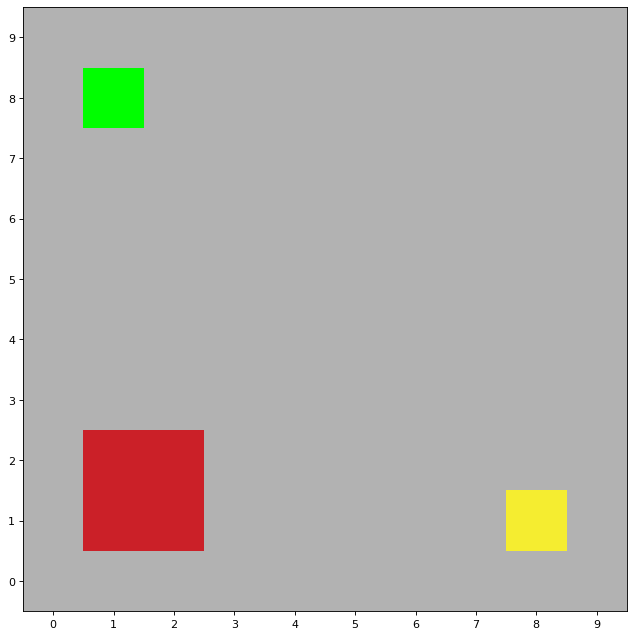

In [4]:
# Setup GridWorld and Q-networks

# Create world from GridWorld
world = GridWorld()
# Setup network
policy_model = setup_network(world)
#make a target network as well
target_model = setup_network(world)
# copy weights from policy to target
target_model.set_weights(policy_model.get_weights())

# Plot model summary
policy_model.summary()

#Make state 
state , player_coordinate = world.make_state(False)

# plot it 
grid_RGB =world.make_RGB_grid(state,None)
#
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
# We have to invert the x and y axis , go over to numpy array instead
plt.imshow(np.swapaxes(np.array(grid_RGB),0,1))
#plt.axis('on')
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, world.size[0], dtype=np.int))
plt.yticks(np.arange(0, world.size[1], dtype=np.int))
plt.show()


# Train network on model 

HERE YOU NEED TO DEFINE PARAMETER VALUES

In [5]:
# Setup system parameters

world.gamma = 0.9 # how much to value the new experience Q(s', a')
world.epsilon_decay = 0.9999 #multiplicative factor that reduces epsilon each step, for no reduction use 1
world.epsilon = 0.4  #initial value of epsilon 
world.wind = 0
# fire spreading
world.prob_spread = 0.5 # 

#update the target network every "update_target_network_period game". Updating target network less often should make
#the system more stable, but also convergence slower
update_target_network_period = 5

#define size of experience replay buffer (how many moves are stored for training) 
#and batchsize (how many moves from memory buffer are used in each training instance)
world.memory_size = 200
world.batchSize = 512
world.memory = deque(maxlen=world.memory_size)   #The experience replay memory


Diagnostics. This is used to print max, min, q-values for states visited in order to get a 
diagnostic on the Q-network; does it produce reasonable values given the reward scheme?

In [6]:
#Diagnostics.  
q_max = 0
q_min = 0


The main loop. It should be all set to run if you have defined the network and parameters above. 

In [7]:
# MAIN LOOP with network
with tf.device("/gpu:0"):
    step_count=0;
    random_start = True
    is_wind = True  # Might be true here, but with wind value set to 0 it doesn't generate random move
    next_player_coordinate = None
    nr_games = 3000  #This is a large number, hopefully it will converge earlier
    # loop over games
    for games in range(nr_games):

        # Display
        print("Game #: %s" % (games,))
        print("Epsilon : %7.4f" % world.epsilon)     
        print("Step count : %s" % step_count) 
        print("End pos %s" % next_player_coordinate)

        # DIAGNOSTICS 
        print("Since updated target: Qmin  %s Qmax %s" % (q_min,q_max))


        # reinitize grid every game will be created at start position
        state , player_coordinate = world.make_state(random_start)

        step_count=0;
        while True :
            step_count+=1

            # use policy network to get q
            q_state = policy_model.predict(state.reshape(1,world.size[0],world.size[1],world.layers))        
            # get best action
            action = np.argmax(q_state)   

            # epsilon greedy
            if np.random.rand() < world.epsilon :
                # take another action
                action=np.random.randint(4)

            # make the move
            next_state ,next_player_coordinate, reward , done = world.make_move(state,action,player_coordinate,is_wind)

            # find max q of the next state using target network
            next_q_max = np.amax(target_model.predict(next_state.reshape(1,world.size[0],world.size[1],world.layers)))

            # Store in memory
            world.memory.extend([(state, q_state, action, reward, next_state, next_q_max, done)])  

            # DIAGNOSTICS UPDATE   =============
            if q_max < np.amax(q_state):
                q_max = np.amax(q_state)
            if q_min > np.amin(q_state):
                q_min = np.amin(q_state)


            #=============================================


            # break if done or two many steps taken 
            if done or (step_count > 400): # 10^2 =100 steps to diffuse through the lattice
                break

            # update state
            state = next_state 
            player_coordinate = next_player_coordinate 

            # let fire spread 
            new_state, fire_spread = world.let_fire_spread(state)
            if fire_spread :
                state = new_state 


        # end of game, time to train the network
        if len(world.memory) > 0 : # if there is something in the memory
            # Version 1
            world.replay_V1(policy_model)
            # Version 2
            #world.replay_V2(target_model,policy_model)
            # epsilon decay
            if world.epsilon > world.epsilon_min:
                world.epsilon *= world.epsilon_decay 

        # update target network 
        if (games % update_target_network_period == 0) :
            print("Update target network")
            # update the weights of the target model
            target_model.set_weights(policy_model.get_weights())
            #reset diagnostic
            q_max = 0
            q_min = 0

        clear_output(wait=True)    
        # end of loop
    


Game #: 2999
Epsilon :  0.2964
Step count : 9
End pos [8, 1]
Since updated target: Qmin  -33.34457 Qmax 104.44685
Train on 200 samples
200/200 [==============================] - 0s 30us/sample - loss: 38.0942 - accuracy: 0.9250


You can stop the Kernel as you like after a number of games and check progress by using the two plotfunctions below. Restarting the loop will reset the counter but not reset the network. 

In [8]:
# Save model, here you could save and load Q-networks to compare
policy_model.save('my_network.h1')  # 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_network.h1\assets


In [9]:
# load model
policy_model = load_model('my_network.h1')

# Plotting : State value function

<Figure size 432x288 with 0 Axes>

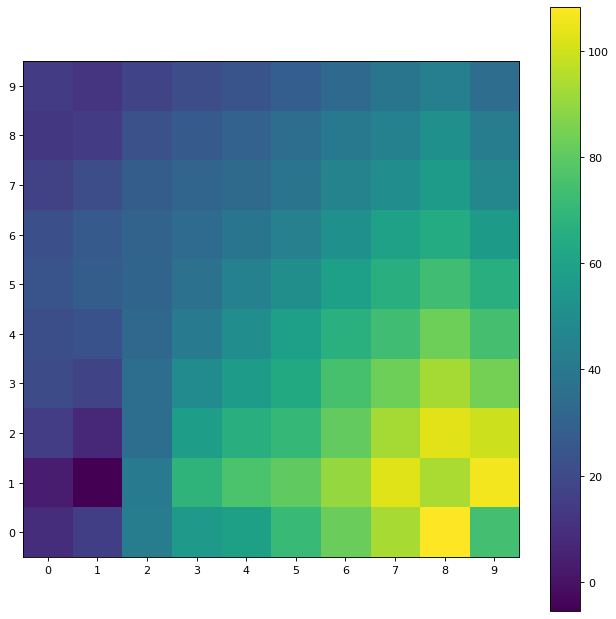

In [10]:
# State value function of network, i.e. max over actions of the Q-function

# Initialize state, this means that the fire is in the strating position
state , player_coordinate = world.make_state(False)

# set position to zero
state[player_coordinate[0],player_coordinate[1],0] = 0

# to plot
z= np.zeros((world.size[0],world.size[1]))

# Go through all possible position of the player and calculate the value of the best action
# according to the network
for x in range(world.size[0]) :
    for y in range(world.size[1]) :
            player_coordinate=[x,y]
            state[player_coordinate[0],player_coordinate[1],0] = 1
            q_state = policy_model.predict(state.reshape(1,world.size[0],world.size[1],world.layers)).reshape(4)
            z[x,y] =q_state.max()
            state[x,y,0] = 0
        

# Plot        
plt.figure()
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(np.swapaxes(z,0,1))
plt.colorbar()
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, world.size[0], dtype=np.int))
plt.yticks(np.arange(0, world.size[1], dtype=np.int))
plt.show()

# Plotting : Dynamic play

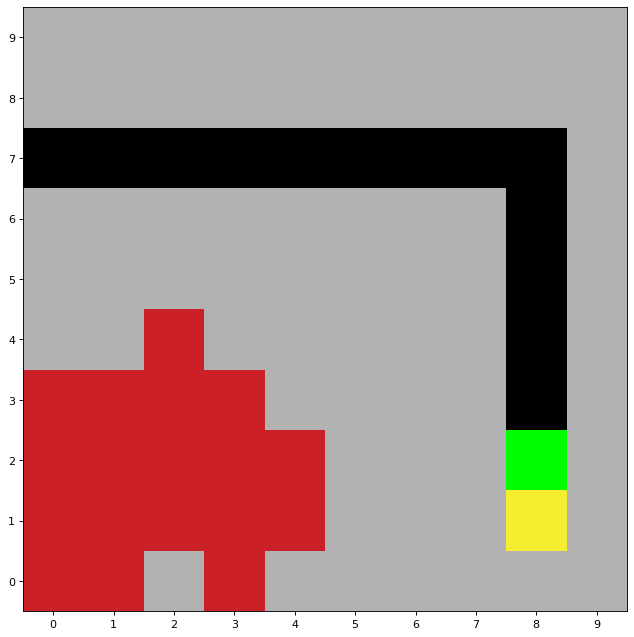

Fire spread


In [14]:
# dynamic game replay

for a in range(100):
    # fire spreading
    world.prob_spread = 0.5
    is_wind = False


    #get original state  
    state, player_coordinate = world.make_state(True)
    path=np.array([player_coordinate])
    
    # setup figure
    fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

    done = False
    count =0
    while (not done) and (count <20) :
        count = count + 1
        
        # plot it 
        plot_grid = world.make_RGB_grid(state,path)
        plt.imshow(np.swapaxes(np.array(plot_grid),0,1))
        plt.gca().invert_yaxis()
        plt.xticks(np.arange(0, world.size[0], dtype=np.int))
        plt.yticks(np.arange(0, world.size[1], dtype=np.int))
        # clear figure and wait
        clear_output(wait=True)
        # time.sleep(1)
        display(fig)

        # find action
        q_state = policy_model.predict(state.reshape(1,world.size[0],world.size[1],world.layers))
        # get best action, no epsilon greedy
        action = np.argmax(q_state)      
        # make the move
        next_state ,next_player_coordinate, reward , done = world.make_move(state,action,player_coordinate,is_wind)

        # update state 
        state = next_state
        player_coordinate = next_player_coordinate

        if not done :
            path=np.append(path,[player_coordinate],axis = 0)

        # let fire spread
        new_state, fire_spread = world.let_fire_spread(state)
        if fire_spread :
            print("Fire spread")
            state = new_state 



    plt.close()
